* Loading data from file /home/ubuntu/projects/S2B/models/run732HF/run732HF.01290.gz ...
* Centering the data...
* Bar defined, aligning to 3.0 kpc
* Realigning bar using |z| < 0.5 
* Bar realigned by 80.98668426330768 degrees


/tmp/ipykernel_1150/3397326402.py:167: RuntimeWarning: invalid value encountered in log10
  plt.contour(xcent, ycent, np.log10(v_stat2d.T), linewidths = 1, linestyles = 'dashed', colors = 'w')


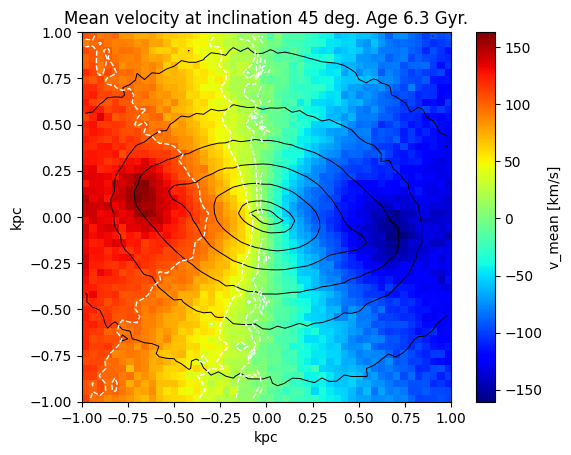

: 

In [10]:
%matplotlib inline
import scipy
from scipy import stats as st
import pynbody as pb
from datetime import datetime
from xml.etree.ElementInclude import include
from matplotlib.colors import LogNorm
from matplotlib.pylab import *
from mpl_toolkits.axes_grid1 import make_axes_locatable

model_dir = 'run732HF/'
base_dir = '/home/ubuntu/projects/S2B/models/' + model_dir
image_dir = '/home/ubuntu/projects/S2B/code/images/' + model_dir
param_fname = base_dir + 'run732HF.param'
snap = 'run732HF.01290.gz'
fname = base_dir + snap

def Gauss_Hermite(w, n):
    """
    Return the Gauss Hermite function of order n, weights w
    Gerhard MNRAS (1993) 265, 213-230
    Equations 3.1 - 3.7
    @author: Steven Gough-Kelly
    """
    w = np.array(w)
    p = scipy.special.hermite(n, monic=False) #hermite poly1d obj
    norm = np.sqrt((2**(n+1))*np.pi*np.math.factorial(n)) # N_n Eqn 3.1
    return (p(w)/norm) * np.exp( -0.5 * w * w )

def GaussHermiteMoment(v, n):
    v = v[np.isfinite(v)] # remove nans&inf
    if len(v) <= 1: # Added SL speed+error catch
        return np.nan
    v_dash = (v - np.mean(v))/np.std(v) # center on 0, norm width to 1sig
    hn = np.sum(Gauss_Hermite(v_dash, n))
    return np.sqrt(4*np.pi) * hn / len(v)

def bar_align(galaxy, rbar, barfrac = 0.5, zlim=0.5, log=False):
    """
    Aligns the bar of pynbody galaxy simulation with the x-axis assuming the
    galaxy disc is already aligned to the XY plane using the inertial tensor.

    Function does not return any values/object. Pynbody functions effect the
    global variable which stores 'galaxy' so rotations within the functions
    are applied to input variable 'galaxy'.

    Parameters
    ----------
    galaxy : pynbody simulation object
        Galaxy object in the XY plane to be aligned.

    rbar : float
        Bar radius in simulation units e.g. kpc.

    barfrac : float
        Fraction of bar length to calculate the inertial tensor within in
        simulation units e.g. kpc.

    zlim : float
        Vertical limit to calculate intertial tensor within in simulation units
        e.g. kpc. Useful in galaxies with thick discs and weak bars.

    log : Bool
        Flag to output print statements.

    Returns
    -------
    None

    """
    if np.isnan(rbar):
        if log:
            print('* Bar undefined, using 1 kpc')
        rbar = 1.0
    elif rbar*barfrac < 1.:
        rbar = 1
        if log:
            print('* Short Bar, using 1 kpc')
    else:
        rbar = rbar*barfrac
        if log:
            print('* Bar defined, aligning to {} kpc'.format(rbar))

    if log:
        print('* Realigning bar using |z| < {} '.format(zlim))

    zfilt = pb.filt.LowPass('z',zlim)&pb.filt.HighPass('z',-zlim)
    rfilt = pb.filt.LowPass('rxy',rbar)

    x = np.array(galaxy[zfilt&rfilt].star['pos'].in_units('kpc'))[:,0]
    y = np.array(galaxy[zfilt&rfilt].star['pos'].in_units('kpc'))[:,1]
    m = np.array(galaxy.star[zfilt&rfilt]['mass'])

    #Calculate the inertia tensor
    I_yy, I_xx, I_xy = np.sum(m*y**2),np.sum(m*x**2),np.sum(m*x*y)
    I = np.array([[I_yy, -I_xy], [-I_xy, I_xx]])

    #Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(I)
    lowest = eigenvalues.argmin()
    maj_axis = eigenvectors[:, lowest]

    #Get the angle we need to rotate by
    r_angle = np.degrees(np.arctan2(maj_axis[1], maj_axis[0]))

    galaxy.rotate_z(-r_angle)

    if log:
        print('* Bar realigned by {} degrees'.format(r_angle))

    return None

def pbload(filename, paramname=None, log=False):
    if log:
        print('* Loading data from file', filename, '...')
    if '::' in filename:
        filename, species = filename.split('::')
        sim = pb.load(filename, paramname=paramname)
        sim = getattr(sim, species)
    else:
        sim = pb.load(filename, paramname=paramname)
    if log:
        print('* Centering the data...')
    pb.analysis.angmom.faceon(sim)
    bar_align(sim,3.,barfrac=1.,zlim=0.5,log=log)
    return sim

# Zoom in
xlim, ylim = 1, 1 #kpc
plt_title = 'Mean velocity'
cbar_label = 'v_mean [km/s]'
bins = 50
cmap = 'jet'

# make the figure and sub plots
incl = 45

s = pbload(fname, param_fname, True)

age = round(s.properties['time'].in_units('Gyr'),2)

s.rotate_x(-incl)
        
d_stat2d,d_xedges,d_yedges,d_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['z'],
                                  statistic = 'count',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)
        
v_stat2d,v_xedges,v_yedges,v_binnum2d = st.binned_statistic_2d(s.star['x'], s.star['y'], s.star['vz'],
                                  statistic = 'mean',
                                  range = [[-xlim,xlim],[-ylim,ylim]],
                                  bins = bins)

image = imshow(v_stat2d.T, 
                        origin = 'lower',
                        extent = [-xlim, xlim, -ylim, ylim ],
                        cmap = cmap)

plt.title(plt_title + ' at inclination ' + str(incl) + ' deg.' ' Age ' + str(age) + ' Gyr.')

xcent = (d_xedges[1:] + d_xedges[:-1]) / 2
ycent = (d_yedges[1:] + d_yedges[:-1]) / 2
plt.contour(xcent, ycent, np.log10(d_stat2d.T), linewidths = 0.7, colors = 'k')
    
xcent = (v_xedges[1:] + v_xedges[:-1]) / 2
ycent = (v_yedges[1:] + v_yedges[:-1]) / 2
plt.contour(xcent, ycent, v_stat2d.T, linewidths = 1, linestyles = 'dashed', colors = 'w')
    
s.rotate_x(incl) # Rotate back to original position
    
# cbar_ax = plt.add_axes([0.85, 0.2, 0.01, 0.6])
cbar = plt.colorbar(image)
cbar.set_label(cbar_label)
plt.xlabel('kpc')
plt.ylabel('kpc')
plt.savefig(snap.replace(".gz","") + '_v_mean_test.png')
plt.show()
